# Crop and resize image

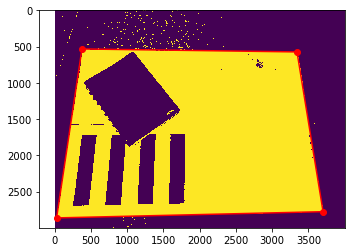

In [1]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('images/terrain.jpg', cv2.IMREAD_COLOR)
(b, g, r) = cv2.split(img)
_,threshold = cv2.threshold(b, 80, 255,  
                            cv2.THRESH_BINARY) 

plt.imshow(threshold)

# Detecting shapes in image by selecting region  
# with same colors or intensity.
contours,_=cv2.findContours(threshold, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) 

board = None

# Searching through every region selected to  
# find the required polygon.
for cnt in contours : 
    area = cv2.contourArea(cnt) 

    # Shortlisting the regions based on there area. 
    if area > 400000:  
        approx = cv2.approxPolyDP(cnt,  
                                  0.015
                                  * cv2.arcLength(cnt, True), True) 
        if len(approx) == 4:
            board = approx

n= len(board)
for i in range(n):
    vertice1 = board[i][0]
    vertice2 = board[(i+1)%n][0]
    plt.scatter(vertice1[0], vertice1[1], c='r')
    plt.plot((vertice1[0], vertice2[0]), (vertice1[1], vertice2[1]), 'r')
   

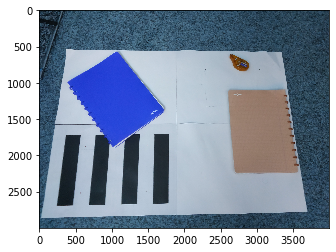

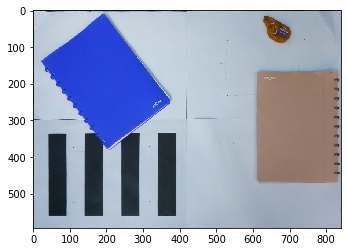

In [2]:
pts0 = np.float32(board)

W, H = 420*2, 297*2
# Define corresponding points in output image
pts1 = np.float32([[0,0],[0,H],[W,H],[W,0]])

# Get perspective transform and apply it
M = cv2.getPerspectiveTransform(pts0,pts1)
rescaled_img = cv2.warpPerspective(img,M,(W,H))

# Save reult
plt.imshow(img)
plt.figure()
plt.imshow(rescaled_img)

# Generate obstacle  map

remove black in background

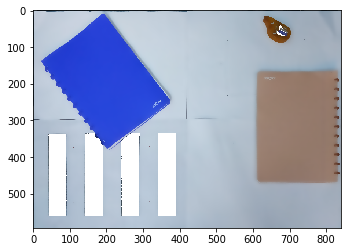

In [3]:
filtered_img = cv2.bilateralFilter(rescaled_img,15, 75, 75)
black_min = np.array([0, 0, 0])
black_max = np.array([80, 80, 80])

mask=cv2.inRange(filtered_img,black_min,black_max)
plt.imshow(filtered_img)

filtered_img[mask>0]=(255,255,255)

plt.imshow(filtered_img)

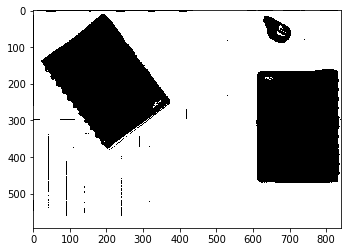

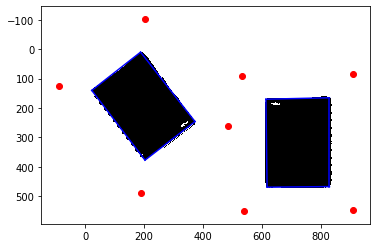

In [4]:
### Image processing filter

threshold_val = 150

### Find the thymio and the destination
(b, g, r) = cv2.split(filtered_img)
ret2, thresh2 = cv2.threshold(b, threshold_val, 255, cv2.THRESH_BINARY_INV)
ret3, thresh3 = cv2.threshold(g, threshold_val, 255, cv2.THRESH_BINARY_INV)
ret4, thresh4 = cv2.threshold(r, threshold_val, 255, cv2.THRESH_BINARY_INV)
bgr_thresh = cv2.merge((thresh2, thresh3, thresh4))

black_and_white = thresh3

plt.imshow(black_and_white, cmap='Greys')

# Detecting shapes in image by selecting region  
# with same colors or intensity. 
contours,_=cv2.findContours(black_and_white, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) 

obstacles =  []

# Searching through every region selected to  
# find the required polygon. 
for cnt in contours : 
    area = cv2.contourArea(cnt) 
   
    # Shortlisting the regions based on there area. 
    if area > 40000:  
        approx = cv2.approxPolyDP(cnt,  
                                  0.01 * cv2.arcLength(cnt, True), True) 
        obstacles.append(approx)
    else:
        cv2.drawContours(black_and_white, [cnt], -1, 0, thickness=-1)
    
plt.figure()

plt.imshow(black_and_white, cmap='Greys')

obstacle_map = black_and_white

from numpy import sqrt
def norm(vec):
    return sqrt(vec[0]**2 + vec[1]**2)

MARGIN = 80

way_points = []

for obstacle in obstacles:
    n= len(obstacle)
    
    for i in range(n):
        vertice1 = obstacle[i][0]
        vertice2 = obstacle[(i+1)%n][0]
        vertice3 = obstacle[(i+2)%n][0]
        
        vec1 = vertice2 - vertice1
        vec2 = vertice2 - vertice3
        
#         normal_vec = vec1/norm(vec1) + vec2/norm(vec2)
        
        way_point = vertice2 + vec1*MARGIN/norm(vec1) + vec2*MARGIN/norm(vec2)
        
        way_points.append(way_point)
        
        plt.scatter(way_point[0], way_point[1], c='r')
        plt.plot((vertice1[0], vertice2[0]), (vertice1[1], vertice2[1]), 'b')

# Generate Graph

In [5]:
import itertools
class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.gScore = np.inf
        self.fScore = np.inf
        self.neighbours = []
    def plot(self, color = 'r'):
        plt.scatter(self.x, self.y, c=color)
    def get_pos(self):
        return self.x, self.y
    def __repr__(self):
        return "node ("+str(self.x)+","+str(self.y)+")"
#     def __eq__(self, other):
#         return self.x == other.x and self.y == other.y
#     def __hash__(self):
#         return hash((self.x, self.y))
    
def sample_image(obstacle_map, x, y):
    max_y = obstacle_map.shape[0]
    max_x = obstacle_map.shape[1]
    if x >= max_x or x < 0 or y >= max_y or y < 0:
        return 0
    else:
        return obstacle_map[y][x]

def noObstacleBetween(p1, p2):
    RESOLUTION = 50
    
    x, y = p1
    x_end, y_end = p2
    forward = np.array([x_end - x, y_end - y])
    
    dist = np.linalg.norm(forward)
    if dist == 0:
        return False
    
    forward = forward/dist
    perp = np.array([forward[1], -forward[0]])
    
    for perp_dist in np.arange(-MARGIN*0.9, MARGIN*0.9, RESOLUTION):
        for forward_dist in np.arange(0, dist, RESOLUTION):
            sample_point = np.array(p1) + forward_dist*forward + perp_dist*perp
#             plt.scatter(sample_point[0], sample_point[1], c='g')
            intensity = sample_image(obstacle_map, int(sample_point[0]), int(sample_point[1]))
            if intensity == 255:
                return False
    return True

class Graph:
    def __init__(self, way_points):
        self.nodes = []
        for way_point in way_points:
            x, y = way_point
            self.nodes.append(Node(x, y))
        for node1, node2 in itertools.combinations(self.nodes, 2):
            if noObstacleBetween(node1.get_pos(), node2.get_pos()):
                node1.neighbours.append(node2)
                node2.neighbours.append(node1)

                x, y = node1.get_pos()
                x_end, y_end = node2.get_pos()
                plt.plot((x, x_end), (y, y_end), 'm', linewidth=1)
                
    def add_new_node(self, node):
        for potential_neighbour in self.nodes:
            if noObstacleBetween(node.get_pos(), potential_neighbour.get_pos()):
                node.neighbours.append(potential_neighbour)
                potential_neighbour.neighbours.append(node)
                
#                 x, y = node.get_pos()
#                 x_end, y_end = potential_neighbour.get_pos()
#                 plt.plot((x, x_end), (y, y_end), 'm', linewidth=1)
        self.nodes.append(node)
        
# plt.imshow(obstacle_map, cmap='Greys')
# noObstacleBetween((10, 10), (1000, 2000))

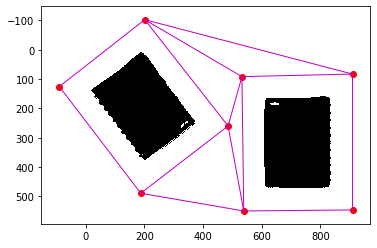

In [6]:
plt.imshow(obstacle_map, cmap='Greys')

graph = Graph(way_points)

for node in graph.nodes:
    node.plot()

# Path finding (A*)

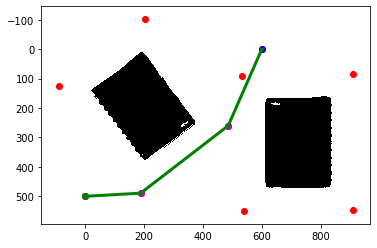

In [7]:
def distance(node1, node2):
    return sqrt((node1.x-node2.x)**2 + (node1.y - node2.y)**2)

### path computation

def A_Star(start, goal, h):
    for node in graph.nodes:
        node.gScore = np.inf
        node.fScore = np.inf
    
    openSet = [start]
    start.gScore = 0
    closedSet = []
    
    cameFrom = dict()
    
    while openSet != []:
        current = min(openSet, key=lambda node: node.fScore)
        if current == goal:
            path = [current]
            while current in cameFrom.keys():
                path.insert(0, cameFrom[current]) 
                current=cameFrom[current]
            return path, closedSet
        
        openSet.remove(current)
        closedSet.append(current)
        
        for neighbour in current.neighbours:
            if neighbour in closedSet:
                continue
                
            tentative_gScore = current.gScore + distance(current, neighbour)
            
            if neighbour not in openSet:
                openSet.append(neighbour)
            
            if tentative_gScore < neighbour.gScore:
                cameFrom[neighbour] = current
                neighbour.gScore = tentative_gScore
                neighbour.fScore = neighbour.gScore + h(neighbour)
    print("No path found to goal")
    return None, closedSet

def compute_path(start, goal, graph):
    graph.add_new_node(start)
    graph.add_new_node(goal)
    
    h = lambda node: distance(node, goal)
    path, closedSet = A_Star(start, goal, h)
    
    # draw
    for node in graph.nodes:
        node.plot()
    for node in closedSet:
        node.plot('m')
    if path!=None:
        for i in range(len(path)-1):
            x, y = path[i].get_pos()
            x_end, y_end = path[i+1].get_pos()
            plt.plot((x, x_end), (y, y_end), 'g', linewidth=3)
    start.plot('g')
    goal.plot('b')
    
    return path


plt.imshow(obstacle_map, cmap='Greys')

start = Node(0, 500)
goal = Node(600, 0)

path = compute_path(start, goal, graph)